# Tests for full linear ridge simulations

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

import aux
from lin_ridge import full_global as C
from lin_ridge import search_global as C_

import PARAMETERS as P


class MockTrial(object):
    pass

#### Test `get_replay_metrics` by ensuring correct values are returned when known.

In [2]:
from lin_ridge.full import get_replay_metrics

class CMock(object):
    T_REPLAY = 0.45
    N_STRIPES = 3
    
class PMock(object):
    DT = 0.1

ts = np.arange(0, 1, PMock.DT)

pfcs = np.array([
    [1., 2, 3, 4, 5, 6],
    [-2, -2, 0, 0, 2, 2]
])

spks = np.zeros((len(ts), pfcs.shape[1]), dtype=bool)
spks[:, 0] = True
spks[:, 4] = True

class RspMock(object):
    
    ts = ts
    pfcs = pfcs
    spks = spks
    
p_mock = {'AREA_H': 6}

replay_fr_correct = 20 / 6
replay_fr_min_correct = 0
replay_fr_max_correct = 5

replay_fr, replay_fr_min, replay_fr_max = get_replay_metrics(RspMock, p_mock, CMock, PMock)

np.testing.assert_almost_equal(replay_fr, replay_fr_correct)
np.testing.assert_almost_equal(replay_fr_min, replay_fr_min_correct)
np.testing.assert_almost_equal(replay_fr_max, replay_fr_max_correct)

print('Tests passed.')

Tests passed.


#### Test `trial_to_stable_ntwk`, which should re-run a replay-only LinRidgeTrial and return one of the stable networks.

In [3]:
# load pre-computed files
pre = {
    'w_n_pc_ec_vs_dist': aux.load(C_.PATH_W_N_PC_EC_VS_DIST),
    'v_g_n_vs_w_n_pc_ec_fr_ec': aux.load(C_.PATH_V_G_N_VS_W_N_PC_EC_FR_EC),
}

In [4]:
from lin_ridge.search import trial_to_stable_ntwk

# build mock trial (copied from LinRidgeTrial 16517)
trial = MockTrial()

trial.seed = 3050

trial.area_h = 0.5
trial.area_w = 2.0
trial.fr_ec = 41.1618320914401
trial.l_pc = 0.0262400374450918
trial.p_a_inh_pc = 0.0873150956083927
trial.p_g_pc_inh = 0.0137217034829851
trial.p_inh = 0.118530941344602
trial.rho_pc = 10588.0101295135
trial.ridge_y = -0.125
trial.w_a_inh_pc = 0.00212093876944484
trial.w_a_pc_pc = 0.00683346136610389
trial.w_g_pc_inh = 0.0108083803733792
trial.z_pc = 0.855577676548951

trial.stability = 0.666666666666667
trial.angle = 0.24754040548792955
trial.activity = 2.6291257054266279
trial.speed = 10.883231571408379

# run trial and extract stable ntwk
ntwk, vs_0, gs_0, spks_forced, extra = trial_to_stable_ntwk(trial, pre, C_, P, test=True)

# ensure rslts match up with originals
stabilities = extra['rslts_all']['STABILITY']
angles = extra['rslts_all']['ANGLE']
activities = extra['rslts_all']['ACTIVITY']
speeds = extra['rslts_all']['SPEED']

print('STABILITY:')
print('MEASURED = {}'.format(np.mean(stabilities)))
print('TRUE = {}'.format(trial.stability))
print('')

print('ANGLE:')
print('MEASURED = {}'.format(np.mean(angles[stabilities == 1])))
print('TRUE = {}'.format(trial.angle))
print('')

print('ACTIVITY:')
print('MEASURED = {}'.format(np.mean(activities[stabilities == 1])))
print('TRUE = {}'.format(trial.activity))
print('')

print('SPEED:')
print('MEASURED = {}'.format(np.mean(speeds[stabilities == 1])))
print('TRUE = {}'.format(trial.speed))
print('')

STABILITY:
MEASURED = 0.6666666666666666
TRUE = 0.666666666666667

ANGLE:
MEASURED = 0.24754040548792955
TRUE = 0.24754040548792955

ACTIVITY:
MEASURED = 2.629125705426628
TRUE = 2.629125705426628

SPEED:
MEASURED = 10.883231571408379
TRUE = 10.883231571408379



Tests passed if measured values are all almost identical to true ones.

#### Test `add_w_up_a_pc_pl` to make sure it expands the ntwk correctly.

In [5]:
ntwk_ = deepcopy(ntwk)

In [6]:
from lin_ridge.full import add_w_up_a_pc_pl

ntwk = add_w_up_a_pc_pl(ntwk_, P)

pc_mask = np.all(~np.isnan(ntwk.pfcs), axis=0)
n_pc = pc_mask.sum()

# check w_up sizes
for syn in ntwk.syns:
    assert ntwk.ws_up_init[syn].shape == (ntwk.n, 2*n_pc)

# check AMPA cxns
w_up_a = ntwk.ws_up_init['AMPA'].copy()
nz_mask_a = np.zeros((ntwk.n, 2*n_pc), dtype=bool)
nz_mask_a[:n_pc, :n_pc] = np.eye(n_pc, dtype=bool)

assert np.sum(ntwk.ws_up_init['AMPA'][~nz_mask_a]) == 0

# check NMDA cxns
w_up_n = ntwk.ws_up_init['NMDA'].copy()
nz_mask_n = np.zeros((ntwk.n, 2*n_pc), dtype=bool)
nz_mask_n[:n_pc, n_pc:] = np.eye(n_pc, dtype=bool)

assert np.sum(ntwk.ws_up_init['NMDA'][~nz_mask_n]) == 0

# check GABA cxns
assert np.sum(ntwk.ws_up_init['GABA']) == 0

print('Tests passed.')

Tests passed.


#### Test `make_replay_trigger` to make sure it builds an input trigger sufficient for triggering replay.

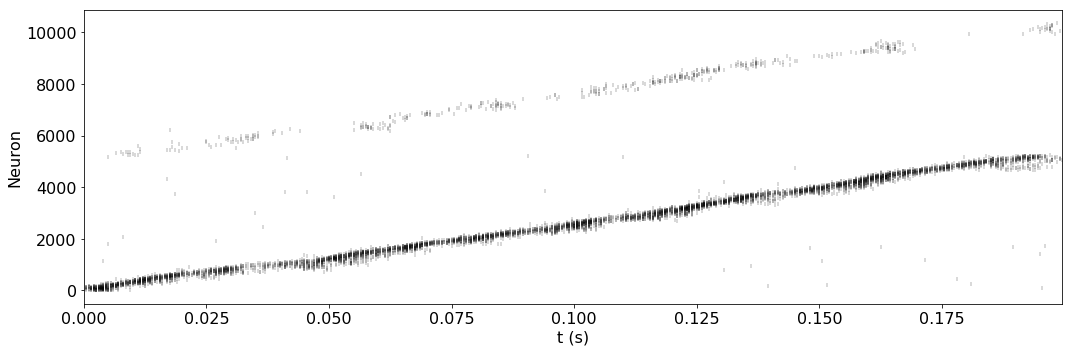

In [7]:
from lin_ridge.full import make_replay_trigger
from lin_ridge.search import trial_to_p, get_ridge_mask
from plot import raster, set_font_size

np.random.seed(6)

TEST_DUR = 0.2

p = trial_to_p(trial)
trigger = make_replay_trigger(ntwk, vs_0, gs_0, spks_forced, p, C, P)

# build upstream spks to test replay
ts = np.arange(0, TEST_DUR, P.DT)

spks_up = np.zeros((len(ts), 2*n_pc))

# replay-triggering spks_up
spks_up[1, :n_pc] = trigger

# background EC spks_up
spks_up[:, n_pc:] = np.random.poisson(trial.fr_ec*P.DT, (len(ts), n_pc))

# run ntwk
rsp = ntwk.run(spks_up=spks_up, dt=P.DT, vs_0=vs_0, gs_0=gs_0)
rsp.pfcs = ntwk.pfcs
rsp.cell_types = ntwk.cell_types

# order cells by cell type, ridge status, and x-position
ridge_mask = get_ridge_mask(rsp, p, C_)
inh_mask = (rsp.cell_types == 'INH')
non_ridge_pc_mask = ~(ridge_mask | inh_mask)

categories = np.zeros(len(rsp.cell_types), dtype='int8')

categories[ridge_mask] = 0
categories[non_ridge_pc_mask] = 1
categories[inh_mask] = 2

order = np.lexsort((rsp.pfcs[0], categories))
        
fig, ax = plt.subplots(1, 1, figsize=(15, 5), tight_layout=True)

raster(ax, rsp.ts, rsp.spks, order=order)

set_font_size(ax, 16)

Test passed if clear sequential activation is observed.

#### Test `run_smln` to ensure that plasticity works and replay triggers are being applied correctly.

In [ ]:
from lin_ridge.full import run_smln
from lin_ridge.full_viz import raster

N = 10

# make mock trial
class MockTrial(object):
    area_h = 0.5
    area_w = 2
    ridge_y = -0.125
    p_inh = 0
    rho_pc = 0
    
    p_a_inh_pc = 0
    w_a_inh_pc = 0
    
    p_g_pc_inh = 0
    w_g_pc_inh = 0
    
    fr_ec = 40
    
    stability = 1
    angle = 0
    activity = 1
    speed = 1

# make mock cached ws_rcr, pfcs, and replay_trigger
ws_rcr = {'AMPA': np.zeros((N, N)), 'NMDA': np.zeros((N, N)), 'GABA': np.zeros((N, N))}
pfcs = np.array([
    [-2/3, -1/3, 0, 1/3, 2/3, -2/3, -1/3, 0, 1/3, 2/3],
    [-.125, -.125, -.125, -.125, -.125, .2, .2, .2, .2, .2],
])
trigger = np.array([30, 30, 0, 0, 0, 0, 0, 0, 0, 0])

cache_file = os.path.join(C.CACHE_DIR, 'ws_rcr_pfcs_replay_trigger_test.npy')
aux.save(cache_file({'ws_rcr': ws_rcr, 'pfcs': pfcs, 'trigger': trigger}))

# make mock global config
class CMock(object):
    
    TRAJ_START_T = 0.1
    TRAJ_END_T = 13.433333
    
    T_EC = 14.
    T_REPLAY = 14.5
    
    ITVL_REPLAY = 0.4
    N_REPLAY = 10
    
    N_STRIPES = 2

    
# run test smln to make sure plasticity works
mock_trial = MockTrial()

rsp = run_smln(
    None, None, None, C, P, C_,
    save=False, seed=0, commit='test',
    cache_file=cache_file, mock_trial=mock_trial)

# show raster plot
fig, axs = raster(rsp.ts, rsp.spks, rsp.pfcs, rsp.cell_types, trial_to_p(mock_trial), CMock, C_, fig_size=(15, 9))

for ax in axs:
    set_font_size(ax, 16)

# show weight changes
assert rsp.ws_plastic.shape[1] == N

ws_plastic_ridge = rsp.ws_plastic[:, :N/2]
ws_plastic_non_ridge = rsp.ws_plastic[:, N/2:]

fig, ax = plt.subplots(1, 1, figsize=(15, 5), tight_layout=True)

ax.plot(rsp.ts, ws_plastic_ridge, color='k', lw=2)
ax.plot(rsp.ts, ws_plastic_non_ridge, color='b', lw=2)

ax.set_xlabel('t (s)')
ax.set_ylabel('W_N_PC_PL')

set_font_size(ax, 16)

Tests passed if:

* Top raster shows sequential activation but only for bottom 5 cells (corresponding to original trajectory)
* Next raster shows periodic spikes in first two cells
* Bottom plot shows staggered large increases in black lines (traj PCs), confined to first half-ish of timecourse.
* Bottom plot shows no increases in blue lines (non-traj PCs).
    